[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Prompt for Google API key if not already set
_set_env("GOOGLE_API_KEY")


Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

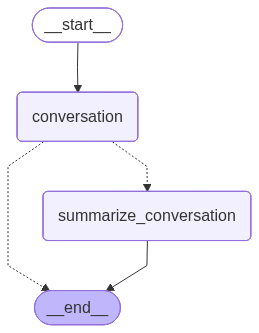

In [2]:
from IPython.display import Image, display
from typing import Literal

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# Use Gemini 2.0 Flash model instead of ChatGPT
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State) -> Literal["summarize_conversation", END]:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile with memory and display
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [3]:
# Create a thread
config = {"configurable": {"thread_id": "a"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Nischala")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hi Nischala! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--9eb776a1-8ba0-4eb5-90cd-b0be44ec8857-0', usage_metadata={'input_tokens': 8, 'output_tokens': 21, 'total_tokens': 29, 'input_token_details': {'cache_read': 0}})}}


Let's now just print the state update.

In [4]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Nischala")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Nischala! It's nice to meet you. How can I help you today?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [5]:
# Start conversation, again
config = {"configurable": {"thread_id": "b"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Nischala")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Nischala
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Nischala
================================== Ai Message ==================================

Hi Nischala! It's nice to meet you. How can I help you today?
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [6]:
config = {"configurable": {"thread_id": "c"}}
input_message = HumanMessage(content="Tell me about Herbivores")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream.

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "d"}}
input_message = HumanMessage(content="Tell me about Herbivores")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='Okay', additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--fb729867-5d79-4e38-bd07-f4d016cf31c4', usage_metadata={'input_tokens': 6, 'output_tokens': 0, 'total_tokens': 6, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=", let'", additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--fb729867-5d79-4e38-bd07-f4d016cf31c4', usage_metadata={'input_tokens': 0, 'input_token_details': {'cache_read': 0}, 'total_tokens': 0, 'output_tokens': 0})}
{'chunk': AIMessageChunk(content='s dive into the world of herbivores!\n\n**What are Herbivores?**\n\n', additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--fb729867-5d79-4e38-bd07-f4d016cf31c4', usage_metadata={'input_tokens': 0, 'input_token_de

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [8]:
config = {"configurable": {"thread_id": "e"}}
input_message = HumanMessage(content="Tell me about Herbivores")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

Okay|, let's dive into the world of herbivores!

**What are Herb|ivores?**

Herbivores are animals that primarily eat plants. Their diet consists of leaves|, stems, roots, seeds, fruits, nectar, and even algae. They are a crucial part of the food chain, converting plant matter into energy that can then| be consumed by carnivores or omnivores.

**Key Characteristics and Adaptations:**

Herbivores have evolved a variety of physical and behavioral adaptations to efficiently consume| and digest plant matter. These adaptations vary depending on the specific type of plant material they eat and their overall lifestyle. Here are some common examples:

*   **Teeth:**
    *   **Flat, broad molars:**  For| grinding plant material.
    *   **Incisors:**  For clipping or tearing vegetation.  Some herbivores, like deer, lack upper incisors and instead have a tough dental pad.
    *   **Diastema:**| A gap between the incisors and molars, allowing the tongue to manipulate plant matter.
*   **Digestive

### Streaming with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [9]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [12]:
from langgraph_sdk import get_client



# This is the URL of the local development server
URL =  "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [14]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Divide 15 by 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="chatbot", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a24ee-1bf9-722c-9e06-106d0777a5dd', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Divide 15 by 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '1d856ad7-0d28-4428-a266-1fc68146080f'}]})
StreamPart(event='error', data={'error': 'RateLimitError', 'message': "Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}"})


The streamed objects have: 

* `event`: Type
* `data`: State

In [18]:
from langchain_core.messages import convert_to_messages

# Create a new thread
thread = await client.threads.create()

# Input message
input_message = HumanMessage(content="Divide 15 by 3")

# Run the assistant (using correct assistant_id)
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="chatbot",   # ✅ Use "chatbot" here
    input={"messages": [input_message]},
    stream_mode="values"
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('=' * 25)


content='Divide 15 by 3' additional_kwargs={} response_metadata={} id='29619f11-630f-4bfe-929c-c3a138675055'


There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [31]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [48]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Divide 15 by 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="chatbot", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)



content='Divide 15 by 3' additional_kwargs={} response_metadata={} id='3c7e8f8c-717f-421d-b770-d4f25933d826'
content='To divide 15 by 3, you are asking how many times 3 fits into 15.\n\n15 ÷ 3 = 5\n\nSo, 15 divided by 3 is **5**.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 8, 'output_tokens': 77, 'total_tokens': 85, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 31}}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--3746cac7-9739-4616-a58a-0f06634ac695-0'


In [45]:
thread = await client.threads.create()
input_message = HumanMessage(content="Divide 15 by 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="chatbot", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [47]:
thread = await client.threads.create()
input_message = HumanMessage(content="Divide 15 by 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="chatbot",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata and response_metadata.get("finish_reason"):
                    print(f"Response Metadata: Finish Reason - {response_metadata['finish_reason']}")                    
        print("-" * 50)

Metadata: Run ID - 019a2517-3173-76ef-b93b-34ac360e425d
--------------------------------------------------
AI: To divide 15 by 3, you are looking for how many times 3 fits into 15.

15 ÷ 3 = 5

So, 15 divided by 3 is **5**.
Response Metadata: Finish Reason - STOP
--------------------------------------------------
AI: To divide 15 by 3, you are looking for how many times 3 fits into 15.

15 ÷ 3 = 5

So, 15 divided by 3 is **5**.
Response Metadata: Finish Reason - STOP
--------------------------------------------------
